In [1]:
from imports import *
import import_data

%matplotlib inline

---

In [2]:
tickers = [filename[:-4] for filename in os.listdir('quandl_data')]

stock_df, prediction_df = import_data.import_data(tickers)
print stock_df.shape
stock_df.tail()

(134150, 10)


,Open,High,Low,Close,Volume,50dravg,200dravg,OC%,HL%,label
4096,0.52,0.53,0.50,0.52,1093100,0.7780,0.38757,0.000000,0.060,0.000000
4097,0.52,0.52,0.50,0.52,226000,0.7808,0.38852,0.000000,0.040,0.000000
4098,0.51,0.52,0.50,0.51,583300,0.7838,0.38927,0.000000,0.040,0.098039
4099,0.51,0.56,0.50,0.56,475900,0.7884,0.39017,0.098039,0.120,0.000000
4100,0.57,0.63,0.56,0.57,1537100,0.7928,0.39107,0.000000,0.125,-0.163934


In [3]:
y = stock_df['label'].values
y = y.reshape(y.shape[0], 1)

stock_df = stock_df.drop('label', axis=1)
X = stock_df.values

print X.shape, y.shape

(134150, 9) (134150, 1)


In [4]:
get_subset = False

if get_subset == True:
    indices = np.random.choice(X.shape[0], 1000)
    X = X[indices,:]
    y = y[indices, :]
    print X.shape, y.shape

---

In [5]:
class NN(object):
    
    def __init__(self, Lambda=0):
        
        # hyperparameters
        self.input_layer_size = 10
        self.hidden_layer_size = 10
        self.output_layer_size = 1
        
        # weights
        self.W1 = np.random.randn(self.input_layer_size, self.hidden_layer_size)
        self.W2 = np.random.randn(self.hidden_layer_size, self.output_layer_size)
        
        # regularization
        self.Lambda = Lambda
        
    def get_weights(self):
        return np.concatenate((self.W1.ravel(), self.W2.ravel()))
    
    def set_weights(self, weights):
        W1_start  = 0
        
        W1_end = (self.hidden_layer_size * self.input_layer_size)
        self.W1 = np.reshape(weights[W1_start:W1_end], (self.input_layer_size,self.hidden_layer_size))
        
        W2_end = W1_end + (self.hidden_layer_size * self.output_layer_size)
        self.W2 = np.reshape(weights[W1_end:W2_end], (self.hidden_layer_size,self.output_layer_size))
    
    def forward_propagate(self, X):
        self.z2 = np.dot(X, self.W1)
        self.a2 = self.activation(self.z2) 
        self.z3 = np.dot(self.a2, self.W2)
        y_hat = self.activation(self.z3)
        return y_hat
    
    def activation(self, z):
        return np.true_divide(1, (1 + np.exp(-z)))

    def visualize_activation(self):
        inputs = np.arange(-6,6,0.01)
        plt.plot(inputs, self.activation(inputs))
        plt.show()
        
    def activation_prime(self, z):
        return np.true_divide(np.exp(-z), ((1 + np.exp(-z))**2))
    
    def visualize_activation_prime(self):
        inputs = np.arange(-6,6,0.01)
        plt.plot(inputs, self.activation(inputs))
        plt.plot(inputs, self.activation_prime(inputs))
        plt.show()
        
    def cost(self, X, y):
        self.y_hat = self.forward_propagate(X)
        left = 0.5 * np.sum((y - self.y_hat)**2)/X.shape[0]
        right = (self.Lambda/2.0)*(np.sum(self.W1**2) + np.sum(self.W2**2))
        return left + right
        
    def cost_prime(self, X, y):
        self.y_hat = self.forward_propagate(X)
        
        delta3 =  np.multiply(-(y - self.y_hat), self.activation_prime(self.z3))
        dJdW2 = np.dot(self.a2.T, delta3)/X.shape[0] + (self.Lambda*self.W2)
        
        delta2 = np.dot(delta3, self.W2.T) * self.activation_prime(self.z2)
        dJdW1 = np.dot(X.T, delta2)/X.shape[0] + (self.Lambda*self.W1)
        
        return dJdW1, dJdW2
                           
    def compute_gradient(self, X, y):
        dJdW1, dJdW2 = self.cost_prime(X, y)
        return np.concatenate((dJdW1.ravel(), dJdW2.ravel()))

In [6]:
def test_activation():
    nn = NN()
    nn.visualize_activation_prime()
#test_activation()

In [7]:
def testNN():
    nn = NN()
    y_hat = nn.forward_propagate(X)
    print y_hat, "\n"
    print y, "\n"
    
    cost1 = nn.cost(X,y)
    print cost1, "\n"

    dJdW1, dJdW2 = nn.cost_prime(X,y)
    print dJdW1, "\n"
    print dJdW2
#testNN()

---

In [8]:
def estimate_gradient(N, X, y):
    weights = N.get_weights()
    estimated_gradient = np.zeros(weights.shape)
    perturb = np.zeros(weights.shape)
    epsilon = 1e-4
    
    for i in xrange(len(weights)):
        perturb[i] = epsilon
        
        N.set_weights(weights + perturb)
        loss2 = N.cost(X,y)
        
        N.set_weights(weights - perturb)
        loss1 = N.cost(X,y)
        
        estimated_gradient[i] = (loss2 - loss1) / (2 * epsilon)
        
        perturb[i] = 0
    
    N.set_weights(weights)
        
    return estimated_gradient

In [9]:
def test_gradient_estimation():
    nn = NN()
    estimated_gradient = estimate_gradient(nn,X,y)
    gradient = nn.compute_gradient(X,y)

    print estimated_gradient[:3]
    print gradient[:3]
    print
    print np.linalg.norm(gradient-estimated_gradient)/np.linalg.norm(gradient+estimated_gradient)   
#test_gradient_estimation()

---

In [10]:
class trainer(object):
    
    def __init__(self, N):
        self.N = N
        
    def callback(self, weights):
        self.N.set_weights(weights)
        self.J.append(self.N.cost(self.train_X, self.train_y))
        self.test_J.append(self.N.cost(self.test_X, self.test_y))
        
    def cost_wrapper(self, weights, X, y):
        self.N.set_weights(weights)
        c = self.N.cost(X, y)
        g = self.N.compute_gradient(X,y)
        
        return c, g
    
    def set_scale(self, X):
        self.scaler = StandardScaler().fit(X)
        
    def get_scale(self):
        return self.scaler
    
    def add_bias(self, X):
        return np.hstack((np.ones((X.shape[0], 1)), X))
    
    def train(self, X,y):
        
        train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)
        
        self.set_scale(train_X)
        scaler = self.get_scale()
        
        train_X = scaler.transform(train_X)
        self.train_X = self.add_bias(train_X)
        self.train_y = train_y # StandardScaler().fit_transform(train_y)
        
        self.test_X = scaler.transform(test_X)
        self.test_X = self.add_bias(test_X)
        self.test_y = test_y # StandardScaler().fit_transform(test_y)
        
        self.J = []
        self.test_J = []
        
        weights0 = self.N.get_weights()
        
        options = {'maxiter':500, 'disp':True}
        _res = optimize.minimize(self.cost_wrapper, weights0, jac=True, method='BFGS', args=(self.train_X,self.train_y), options=options, callback=self.callback)
        
        self.N.set_weights(_res.x)
        self.optimization_results = _res

Optimization terminated successfully.
         Current function value: 0.015140
         Iterations: 43
         Function evaluations: 46
         Gradient evaluations: 46

time for training: 9.45 seconds


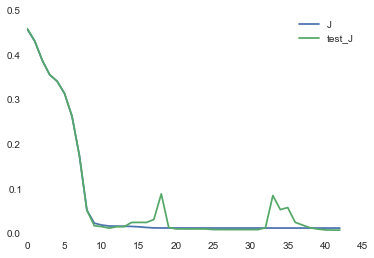

In [13]:
time0 = time()

nn = NN(Lambda=0.01) # 0.0001
Trainer = trainer(nn)
Trainer.train(X,y)

print "\ntime for training:", np.round((time() - time0),2), "seconds"

plt.plot(Trainer.J)
plt.plot(Trainer.test_J)
plt.legend(['J', 'test_J'])
plt.show()

---

In [14]:
pred_df = prediction_df[prediction_df['label'].apply(np.isnan) == True]
pred_tickers = pred_df['ticker'].unique()
pred_X = pred_df.drop(['ticker','label'], axis=1).values

for i in xrange(pred_X.shape[0]):
    scaler = Trainer.get_scale()
    x = scaler.transform(pred_X[i:i+1,0:9])
    x = Trainer.add_bias(x)
    y_hat = nn.forward_propagate(x)
    print str(i).rjust(2), str(pred_tickers[i]).rjust(4), np.round(y_hat[0][0],2)

 0 ABIO 0.1
 1 ACOR 0.1
 2 AERI 0.1
 3 AFFX 0.1
 4 AGEN 0.1
 5 ARIA 0.1
 6 ARNA 0.1
 7 ARWR 0.1
 8 ATNM 0.1
 9 AVXL 0.09
10 AXDX 0.1
11  AXN 0.1
12 BABY 0.1
13 BCRX 0.1
14 BGMD 0.09
15 BIIB 0.1
16 BLUE 0.1
17 BRKR 0.1
18 CBMG 0.1
19 CBPO 0.1
20 CGEN 0.1
21 CLDN 0.1
22 CLDX 0.1
23 COHR 0.1
24 CPHD 0.1
25 CPRX 0.1
26 CRIS 0.1
27 CYBX 0.1
28 CYNO 0.1
29 CYTR 0.1
30 DSCO 0.1
31 DYAX 0.1
32 ECYT 0.1
33 ENZN 0.1
34 ETRM 0.1
35 EXAS 0.1
36 EXEL 0.1
37 FATE 0.1
38 FEIC 0.1
39 FLDM 0.1
40 GILD 0.1
41 GNCA 0.1
42 HALO 0.1
43 IART 0.1
44 IDRA 0.1
45 IDXX 0.1
46 ILMN 0.1
47 IMMU 0.1
48 IMRS 0.09
49 INCY 0.1
50  INO 0.1
51 LPCN 0.1
52 MEIP 0.09
53 MNKD 0.1
54 OREX 0.1
55 PGNX 0.1
56 QLTI 0.1
57 RMTI 0.1
58 SGYP 0.1
59  SYN 0.1
60 THLD 0.1
61 TNXP 0.1
62 TPIV 0.09
